# Machine Learning Analysis: Predicting T1 Outcomes in PE4MOVE Intervention Study

## 📋 Project Overview

This notebook presents a comprehensive machine learning analysis to predict physical activity outcomes at Time 1 (T1 follow-up) using baseline (T0) measurements from the PE4MOVE intervention study.

### Research Questions:
- Can we predict follow-up physical activity levels from baseline characteristics?
- Which baseline features are most predictive of intervention outcomes?
- What model architectures work best for behavioral prediction?

### Target Variables (T1 Outcomes):
1. **MVPA_Frequency_T1**: Moderate-to-vigorous physical activity frequency
2. **MVPA_Usual_Week_T1**: MVPA during a typical week
3. **Leisure_Exercise_T1**: Leisure-time exercise engagement
4. **Leisure_PA_T1**: Leisure-time physical activity levels

---

## 📊 Dataset Information

- **Sample Size**: 710 participants (intervention group)
- **Features**: 24 predictor variables (20 baseline + 4 engineered)
- **Data Quality**: Complete dataset with no missing values
- **Study Design**: Pre-post intervention with T0 (baseline) and T1 (follow-up) measurements

---

**Author**: Lena's ML Analysis  
**Date**: January 2026  
**Framework**: Scikit-learn, Python 3


## 1. Import Libraries and Setup

Setting up the analysis environment with necessary machine learning and visualization libraries.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All libraries imported successfully!")
print(f"📊 Random seed set to: {RANDOM_STATE}")

✅ All libraries imported successfully!
📊 Random seed set to: 42


## 2. Data Loading and Exploration

Loading the clean intervention group dataset and performing initial exploration to understand the data structure, distributions, and target variables.


In [4]:
# Load the clean dataset
df = pd.read_csv('data/intervention_group_clean.csv')

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nDataset shape: {df.shape}")
print(f"Number of participants: {len(df)}")
print(f"Number of variables: {len(df.columns)}")

print("\n" + "=" * 80)
print("DATA STRUCTURE")
print("=" * 80)
df.info()

print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(df.describe())

DATASET OVERVIEW

Dataset shape: (710, 25)
Number of participants: 710
Number of variables: 25

DATA STRUCTURE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                710 non-null    int64  
 1   Sex                                710 non-null    int64  
 2   MVPA_Frequency_T0                  710 non-null    int64  
 3   Leisure_Exercise_T0                710 non-null    int64  
 4   YAP_sedentary_general_T0           710 non-null    int64  
 5   Leisure_PA_T0                      710 non-null    int64  
 6   MVPA_Usual_Week_T0                 710 non-null    int64  
 7   Group_Final                        710 non-null    object 
 8   MVPA_Frequency_T1                  710 non-null    float64
 9   MVPA_Usual_Week_T1                 710 non-null    float64
 10  Leisure_Exe

In [5]:
# Check for missing values
print("=" * 80)
print("DATA QUALITY CHECK")
print("=" * 80)

missing = df.isnull().sum()
if missing.sum() == 0:
    print("\n✅ No missing values found - dataset is complete!")
else:
    print("\n⚠️  Missing values detected:")
    print(missing[missing > 0])

# Display target variables
target_vars = ['MVPA_Frequency_T1', 'MVPA_Usual_Week_T1', 'Leisure_Exercise_T1', 'Leisure_PA_T1']
print("\n" + "=" * 80)
print("TARGET VARIABLES (T1 OUTCOMES)")
print("=" * 80)
print(df[target_vars].describe())

DATA QUALITY CHECK

✅ No missing values found - dataset is complete!

TARGET VARIABLES (T1 OUTCOMES)
       MVPA_Frequency_T1  MVPA_Usual_Week_T1  Leisure_Exercise_T1  \
count         710.000000          710.000000           710.000000   
mean            3.483099            3.580282             3.204225   
std             1.834975            1.700794             1.454232   
min             0.000000            0.000000             0.000000   
25%             2.000000            2.000000             3.000000   
50%             3.000000            4.000000             3.000000   
75%             5.000000            5.000000             4.000000   
max             7.000000            7.000000             5.000000   

       Leisure_PA_T1  
count     710.000000  
mean        2.895775  
std         1.097688  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         4.000000  
max         5.000000  


### 📊 Visualize Target Variable Distributions

Understanding the distribution of our outcome variables is crucial for selecting appropriate models and evaluation metrics.


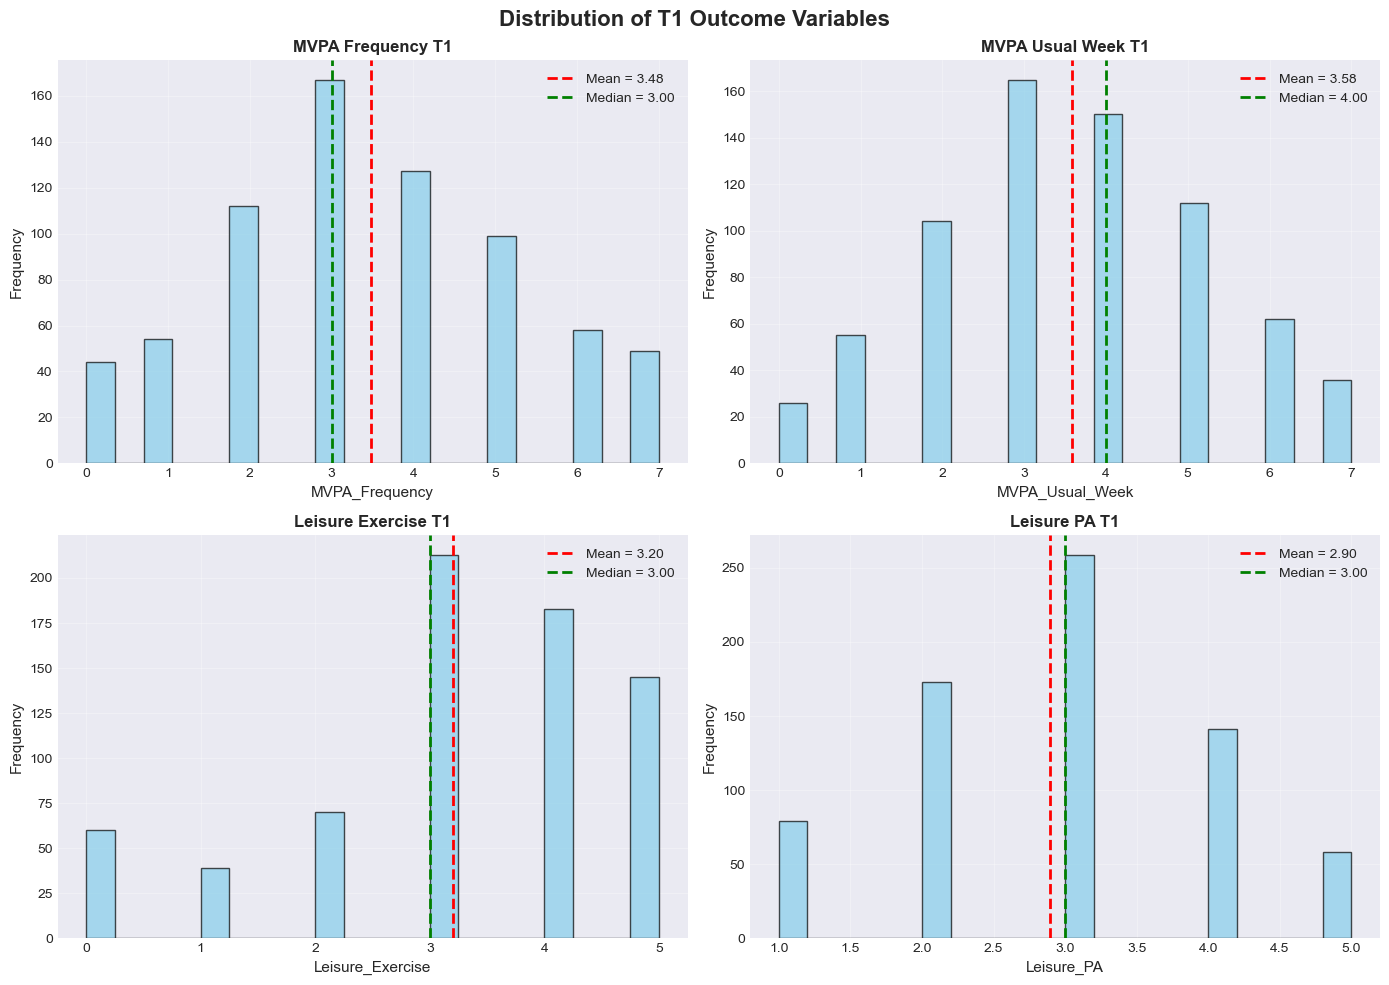

📈 All target variables show reasonable distributions for regression modeling.


In [6]:
# Visualize target variable distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of T1 Outcome Variables', fontsize=16, fontweight='bold')

for idx, target in enumerate(target_vars):
    ax = axes[idx // 2, idx % 2]
    
    # Histogram with KDE
    ax.hist(df[target], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.axvline(df[target].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {df[target].mean():.2f}')
    ax.axvline(df[target].median(), color='green', linestyle='--', linewidth=2, label=f'Median = {df[target].median():.2f}')
    
    ax.set_xlabel(target.replace('_T1', ''), fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(target.replace('_', ' '), fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 All target variables show reasonable distributions for regression modeling.")

## 3. Feature Engineering

Creating composite features that capture complex relationships in the data:

1. **HG_Average_T0**: Average hand grip strength (combining left and right)
2. **PA_Composite_T0**: Overall physical activity level at baseline
3. **Fitness_Composite_T0**: Normalized composite fitness score (6MW, SLJ, HG)
4. **Psychological_Composite_T0**: Combined motivation and self-monitoring scores

These engineered features help capture broader constructs that may be more predictive than individual measures.


In [7]:
# Define baseline features
baseline_features = [
    'Age', 'Sex',
    'MVPA_Frequency_T0', 'Leisure_Exercise_T0', 'YAP_sedentary_general_T0',
    'Leisure_PA_T0', 'MVPA_Usual_Week_T0',
    'PE_hours_T0', 'Extracurricular_Session_Coach_T0', 'Extracurricular_Session_School_T0',
    'COVID_impact_T0',
    'SixMW_T0', 'SLJ_T0', 'HG_Right_T0', 'HG_Left_T0',
    'Motivation_T0', 'Self_Monitoring_T0',
    'BMI_for_age_zscore', 'BMI_category',
    'Group_Final'
]

print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Create a copy for feature engineering
df_ml = df.copy()

# 1. Hand grip average
df_ml['HG_Average_T0'] = (df_ml['HG_Right_T0'] + df_ml['HG_Left_T0']) / 2
print("\n✅ Created: HG_Average_T0 (average hand grip strength)")

# 2. Physical activity composite score at T0
df_ml['PA_Composite_T0'] = (
    df_ml['MVPA_Frequency_T0'] + 
    df_ml['Leisure_Exercise_T0'] + 
    df_ml['Leisure_PA_T0'] + 
    df_ml['MVPA_Usual_Week_T0']
) / 4
print("✅ Created: PA_Composite_T0 (baseline PA composite)")

# 3. Fitness composite (normalized)
fitness_cols = ['SixMW_T0', 'SLJ_T0', 'HG_Average_T0']
scaler_fitness = StandardScaler()
fitness_scaled = scaler_fitness.fit_transform(df_ml[fitness_cols])
df_ml['Fitness_Composite_T0'] = fitness_scaled.mean(axis=1)
print("✅ Created: Fitness_Composite_T0 (normalized fitness composite)")

# 4. Psychological composite
df_ml['Psychological_Composite_T0'] = (df_ml['Motivation_T0'] + df_ml['Self_Monitoring_T0']) / 2
print("✅ Created: Psychological_Composite_T0 (motivation + self-monitoring)")

# Add engineered features to feature list
engineered_features = [
    'HG_Average_T0', 'PA_Composite_T0', 
    'Fitness_Composite_T0', 'Psychological_Composite_T0'
]

all_features = baseline_features + engineered_features

print(f"\n📊 Feature Summary:")
print(f"   Total features: {len(all_features)}")
print(f"   - Baseline features: {len(baseline_features)}")
print(f"   - Engineered features: {len(engineered_features)}")

FEATURE ENGINEERING

✅ Created: HG_Average_T0 (average hand grip strength)
✅ Created: PA_Composite_T0 (baseline PA composite)
✅ Created: Fitness_Composite_T0 (normalized fitness composite)
✅ Created: Psychological_Composite_T0 (motivation + self-monitoring)

📊 Feature Summary:
   Total features: 24
   - Baseline features: 20
   - Engineered features: 4


## 4. Data Preparation for Machine Learning

Preparing the feature matrix by encoding categorical variables (Sex, BMI category, Group) into numerical format required by ML algorithms.


In [8]:
# Prepare feature matrix
X = df_ml[all_features].copy()

print("=" * 80)
print("DATA PREPARATION")
print("=" * 80)

# Encode categorical variables
le_sex = LabelEncoder()
X['Sex'] = le_sex.fit_transform(X['Sex'])
print(f"\n✅ Encoded Sex: {dict(zip(le_sex.classes_, le_sex.transform(le_sex.classes_)))}")

le_bmi = LabelEncoder()
X['BMI_category'] = le_bmi.fit_transform(X['BMI_category'])
print(f"✅ Encoded BMI_category: {dict(zip(le_bmi.classes_, le_bmi.transform(le_bmi.classes_)))}")

le_group = LabelEncoder()
X['Group_Final'] = le_group.fit_transform(X['Group_Final'])
print(f"✅ Encoded Group_Final: {dict(zip(le_group.classes_, le_group.transform(le_group.classes_)))}")

print(f"\n📊 Final feature matrix shape: {X.shape}")
print(f"   Features ready for modeling: {len(all_features)}")

DATA PREPARATION

✅ Encoded Sex: {1: 0, 2: 1}
✅ Encoded BMI_category: {'Below normal': 0, 'Normal': 1, 'Obesity': 2, 'Overweight': 3, 'Thinness': 4}
✅ Encoded Group_Final: {'A': 0}

📊 Final feature matrix shape: (710, 24)
   Features ready for modeling: 24


## 5. Model Training Framework

### Machine Learning Models Tested:

1. **Random Forest**: Ensemble of decision trees, handles non-linear relationships
2. **Gradient Boosting**: Sequential ensemble method, builds trees iteratively
3. **Ridge Regression**: Linear model with L2 regularization
4. **Lasso Regression**: Linear model with L1 regularization (feature selection)
5. **ElasticNet**: Combines L1 and L2 regularization
6. **Support Vector Regression (SVR)**: Kernel-based method for non-linear patterns
7. **K-Nearest Neighbors**: Instance-based learning algorithm

### Evaluation Metrics:
- **R² Score**: Proportion of variance explained (higher is better)
- **RMSE**: Root Mean Squared Error (lower is better)
- **MAE**: Mean Absolute Error (lower is better)
- **Cross-Validation R²**: 5-fold CV to assess generalization


In [9]:
def train_and_evaluate_models(X, y, target_name, test_size=0.2, random_state=42):
    """
    Train multiple ML models and evaluate their performance.
    
    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : Series
        Target variable
    target_name : str
        Name of the target variable
    test_size : float
        Proportion of data for testing
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    results : dict
        Performance metrics for each model
    predictions : dict
        Predictions and model objects
    train/test splits
    scaler
    """
    print(f"\n{'='*80}")
    print(f"🎯 MODELING TARGET: {target_name}")
    print(f"{'='*80}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"\nDataset split:")
    print(f"  Training set: {len(X_train)} samples ({(1-test_size)*100:.0f}%)")
    print(f"  Test set: {len(X_test)} samples ({test_size*100:.0f}%)")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=random_state),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, random_state=random_state),
        'SVR': SVR(kernel='rbf'),
        'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
    }
    
    results = {}
    predictions = {}
    
    print(f"\n🤖 Training {len(models)} different models...")
    print("\n{:<25s} | {:<10s} | {:<10s} | {:<25s}".format('Model', 'R²', 'RMSE', 'CV R² (mean ± std)'))
    print("-" * 80)
    
    for name, model in models.items():
        # Determine if model needs scaling
        needs_scaling = name in ['Ridge Regression', 'Lasso Regression', 'ElasticNet', 'SVR', 'K-Nearest Neighbors']
        
        # Train model
        if needs_scaling:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'CV_R2_mean': cv_scores.mean(),
            'CV_R2_std': cv_scores.std()
        }
        
        predictions[name] = {
            'y_test': y_test,
            'y_pred': y_pred,
            'model': model,
            'scaler': scaler if needs_scaling else None
        }
        
        print("{:<25s} | {:<10.4f} | {:<10.4f} | {:.4f} ± {:.4f}".format(
            name, r2, rmse, cv_scores.mean(), cv_scores.std()))
    
    return results, predictions, X_train, X_test, y_train, y_test, scaler

print("✅ Model training function defined successfully!")

✅ Model training function defined successfully!


## 6. Visualization Functions

Functions to create comprehensive visualizations of model performance, predictions, and feature importance.


In [10]:
def plot_model_comparison(results, target_name):
    """Create visualization comparing model performance"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Model Comparison - {target_name}', fontsize=16, fontweight='bold')
    
    models = list(results.keys())
    
    # R² Score
    r2_scores = [results[m]['R2'] for m in models]
    axes[0].barh(models, r2_scores, color='skyblue')
    axes[0].set_xlabel('R² Score', fontsize=12)
    axes[0].set_title('R² Score (Higher is Better)', fontsize=12, fontweight='bold')
    axes[0].axvline(x=0, color='black', linewidth=0.5)
    for i, v in enumerate(r2_scores):
        axes[0].text(v, i, f' {v:.3f}', va='center', fontsize=9)
    
    # RMSE
    rmse_scores = [results[m]['RMSE'] for m in models]
    axes[1].barh(models, rmse_scores, color='lightcoral')
    axes[1].set_xlabel('RMSE', fontsize=12)
    axes[1].set_title('Root Mean Squared Error (Lower is Better)', fontsize=12, fontweight='bold')
    for i, v in enumerate(rmse_scores):
        axes[1].text(v, i, f' {v:.3f}', va='center', fontsize=9)
    
    # Cross-validation R² with error bars
    cv_means = [results[m]['CV_R2_mean'] for m in models]
    cv_stds = [results[m]['CV_R2_std'] for m in models]
    axes[2].barh(models, cv_means, xerr=cv_stds, color='lightgreen', capsize=5)
    axes[2].set_xlabel('Cross-Validation R² Score', fontsize=12)
    axes[2].set_title('5-Fold CV R² (with std)', fontsize=12, fontweight='bold')
    axes[2].axvline(x=0, color='black', linewidth=0.5)
    
    plt.tight_layout()
    return fig


def plot_predictions(predictions, best_model_name, target_name):
    """Plot actual vs predicted values for the best model"""
    pred_data = predictions[best_model_name]
    y_test = pred_data['y_test']
    y_pred = pred_data['y_pred']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{best_model_name} - {target_name}', fontsize=16, fontweight='bold')
    
    # Scatter plot
    axes[0].scatter(y_test, y_pred, alpha=0.6, s=50, color='steelblue', edgecolors='black', linewidth=0.5)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Values', fontsize=12)
    axes[0].set_ylabel('Predicted Values', fontsize=12)
    axes[0].set_title('Actual vs Predicted', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Residual plot
    residuals = y_test - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, s=50, color='coral', edgecolors='black', linewidth=0.5)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Values', fontsize=12)
    axes[1].set_ylabel('Residuals', fontsize=12)
    axes[1].set_title('Residual Plot', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def get_feature_importance(predictions, best_model_name, feature_names, target_name, top_n=20):
    """Get and plot feature importance for tree-based models"""
    model = predictions[best_model_name]['model']
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]
        
        fig, ax = plt.subplots(figsize=(10, 8))
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(indices)))
        ax.barh(range(len(indices)), importances[indices], color=colors)
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.set_xlabel('Feature Importance', fontsize=12)
        ax.set_title(f'Top {top_n} Feature Importances - {best_model_name}\n{target_name}', 
                     fontsize=14, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        return fig, importances
    else:
        print(f"⚠️  {best_model_name} does not have feature_importances_ attribute")
        return None, None

print("✅ Visualization functions defined successfully!")

✅ Visualization functions defined successfully!


## 7. Train Models for All T1 Outcomes

Now we'll train all 7 models for each of the 4 target variables and compare their performance.


In [11]:
# Store all results
all_results = {}
all_predictions = {}

# Train models for each target
for target in target_vars:
    y = df_ml[target].copy()
    
    results, predictions, X_train, X_test, y_train, y_test, scaler = train_and_evaluate_models(
        X, y, target
    )
    
    all_results[target] = results
    all_predictions[target] = predictions
    
    # Find best model
    best_model = max(results.items(), key=lambda x: x[1]['R2'])
    best_model_name = best_model[0]
    
    print(f"\n{'='*80}")
    print(f"🏆 BEST MODEL FOR {target}: {best_model_name}")
    print(f"{'='*80}")
    print(f"   R² Score: {best_model[1]['R2']:.4f}")
    print(f"   RMSE: {best_model[1]['RMSE']:.4f}")
    print(f"   MAE: {best_model[1]['MAE']:.4f}")
    print(f"   CV R² Mean: {best_model[1]['CV_R2_mean']:.4f}")
    print(f"   CV R² Std: {best_model[1]['CV_R2_std']:.4f}")

print("\n" + "="*80)
print("✅ ALL MODELS TRAINED SUCCESSFULLY!")
print("="*80)


🎯 MODELING TARGET: MVPA_Frequency_T1

Dataset split:
  Training set: 568 samples (80%)
  Test set: 142 samples (20%)

🤖 Training 7 different models...

Model                     | R²         | RMSE       | CV R² (mean ± std)       
--------------------------------------------------------------------------------
Random Forest             | 0.4659     | 1.3203     | 0.3383 ± 0.0780
Gradient Boosting         | 0.4060     | 1.3925     | 0.3366 ± 0.0856
Ridge Regression          | 0.5111     | 1.2633     | 0.3768 ± 0.0634
Lasso Regression          | 0.0953     | 1.7185     | 0.0694 ± 0.0298
ElasticNet                | 0.3166     | 1.4935     | 0.2641 ± 0.0245
SVR                       | 0.4491     | 1.3409     | 0.3544 ± 0.0599
K-Nearest Neighbors       | 0.3509     | 1.4555     | 0.2870 ± 0.0555

🏆 BEST MODEL FOR MVPA_Frequency_T1: Ridge Regression
   R² Score: 0.5111
   RMSE: 1.2633
   MAE: 1.0073
   CV R² Mean: 0.3768
   CV R² Std: 0.0634

🎯 MODELING TARGET: MVPA_Usual_Week_T1

Dataset 

### 7.1 Results for MVPA Frequency T1

Detailed visualizations and analysis for predicting mvpa frequency at follow-up.


Best Model: Ridge Regression
Performance Metrics:
  R² Score: 0.5111
  RMSE: 1.2633
  MAE: 1.0073


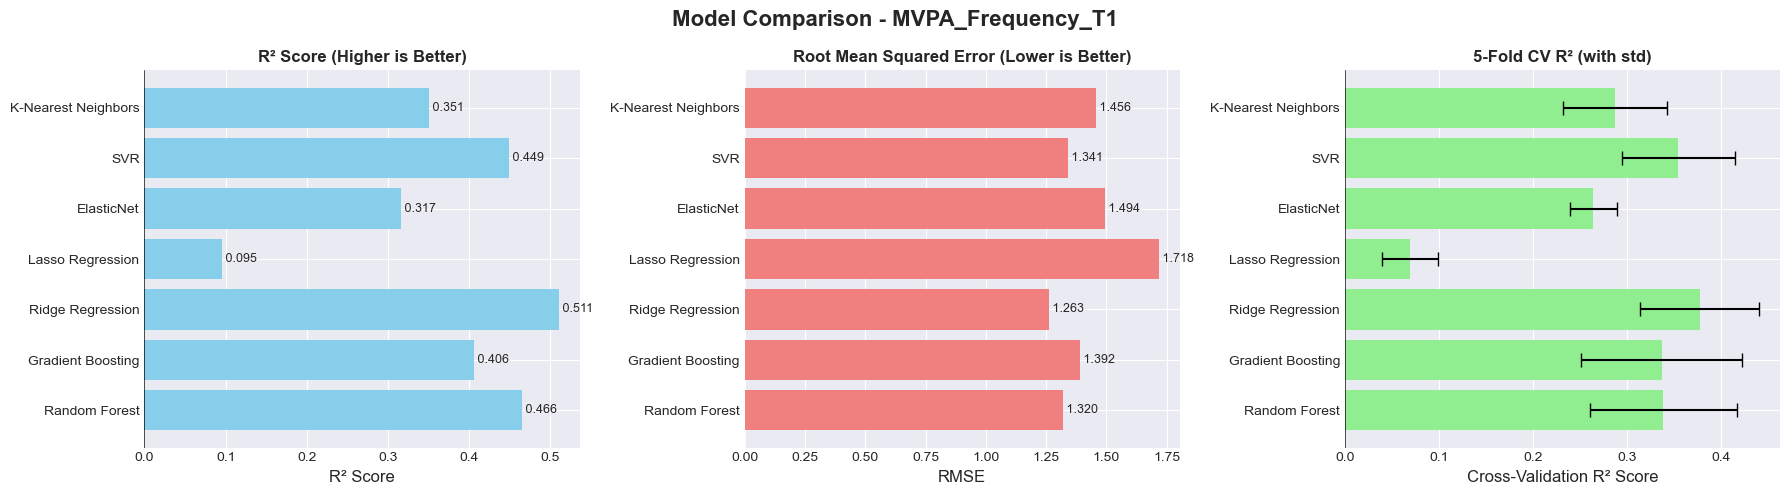

In [12]:
# Model comparison for MVPA_Frequency_T1
target_name = 'MVPA_Frequency_T1'
results = all_results[target_name]
predictions = all_predictions[target_name]

# Find best model
best_model = max(results.items(), key=lambda x: x[1]['R2'])
best_model_name = best_model[0]

print(f"Best Model: {best_model_name}")
print(f"Performance Metrics:")
print(f"  R² Score: {best_model[1]['R2']:.4f}")
print(f"  RMSE: {best_model[1]['RMSE']:.4f}")
print(f"  MAE: {best_model[1]['MAE']:.4f}")

# Plot model comparison
fig = plot_model_comparison(results, target_name)
plt.show()

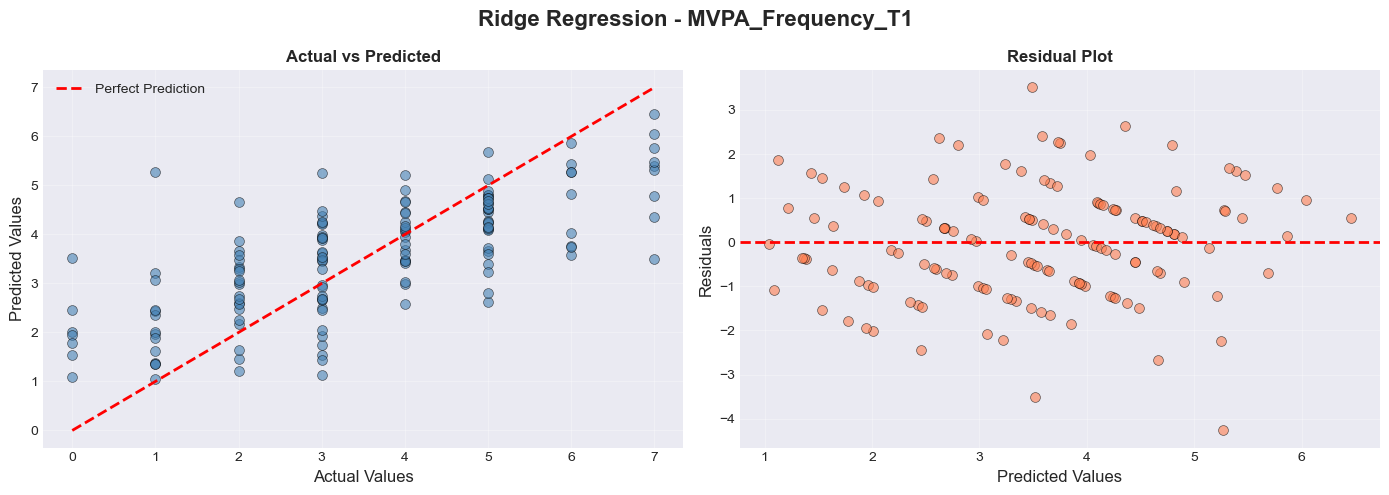

In [13]:
# Prediction plot for MVPA_Frequency_T1
fig = plot_predictions(predictions, best_model_name, target_name)
plt.show()

In [14]:
# Feature importance (if available) for MVPA_Frequency_T1
fig, importances = get_feature_importance(predictions, best_model_name, all_features, target_name)
if fig:
    plt.show()

⚠️  Ridge Regression does not have feature_importances_ attribute


### 7.2 Results for MVPA Usual Week T1

Detailed visualizations and analysis for predicting mvpa usual week at follow-up.


Best Model: Ridge Regression
Performance Metrics:
  R² Score: 0.5834
  RMSE: 1.0960
  MAE: 0.8740


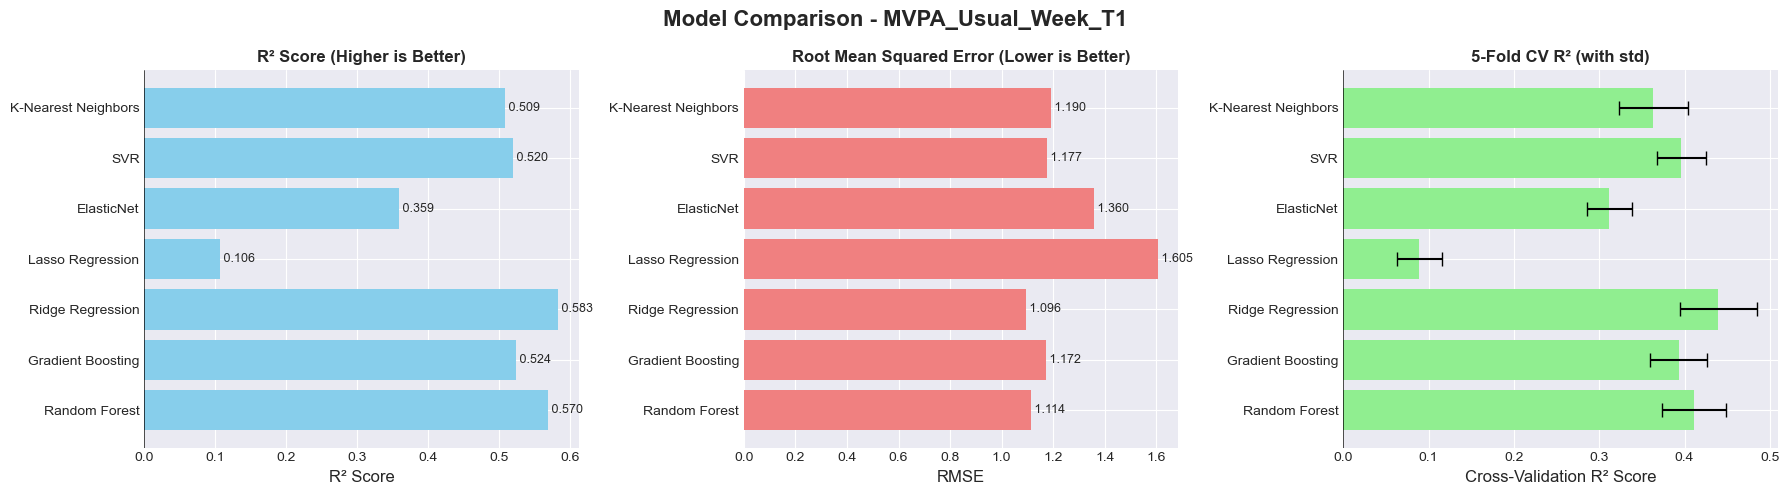

In [15]:
# Model comparison for MVPA_Usual_Week_T1
target_name = 'MVPA_Usual_Week_T1'
results = all_results[target_name]
predictions = all_predictions[target_name]

# Find best model
best_model = max(results.items(), key=lambda x: x[1]['R2'])
best_model_name = best_model[0]

print(f"Best Model: {best_model_name}")
print(f"Performance Metrics:")
print(f"  R² Score: {best_model[1]['R2']:.4f}")
print(f"  RMSE: {best_model[1]['RMSE']:.4f}")
print(f"  MAE: {best_model[1]['MAE']:.4f}")

# Plot model comparison
fig = plot_model_comparison(results, target_name)
plt.show()

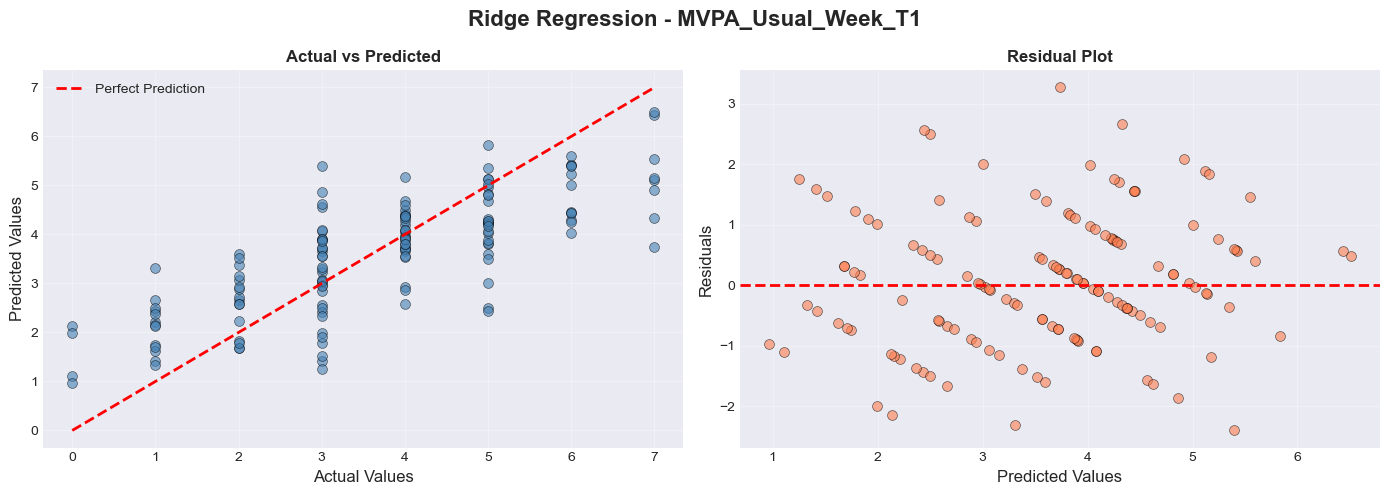

In [16]:
# Prediction plot for MVPA_Usual_Week_T1
fig = plot_predictions(predictions, best_model_name, target_name)
plt.show()

In [17]:
# Feature importance (if available) for MVPA_Usual_Week_T1
fig, importances = get_feature_importance(predictions, best_model_name, all_features, target_name)
if fig:
    plt.show()

⚠️  Ridge Regression does not have feature_importances_ attribute


### 7.3 Results for Leisure Exercise T1

Detailed visualizations and analysis for predicting leisure exercise at follow-up.


Best Model: K-Nearest Neighbors
Performance Metrics:
  R² Score: 0.4157
  RMSE: 1.2276
  MAE: 0.9324


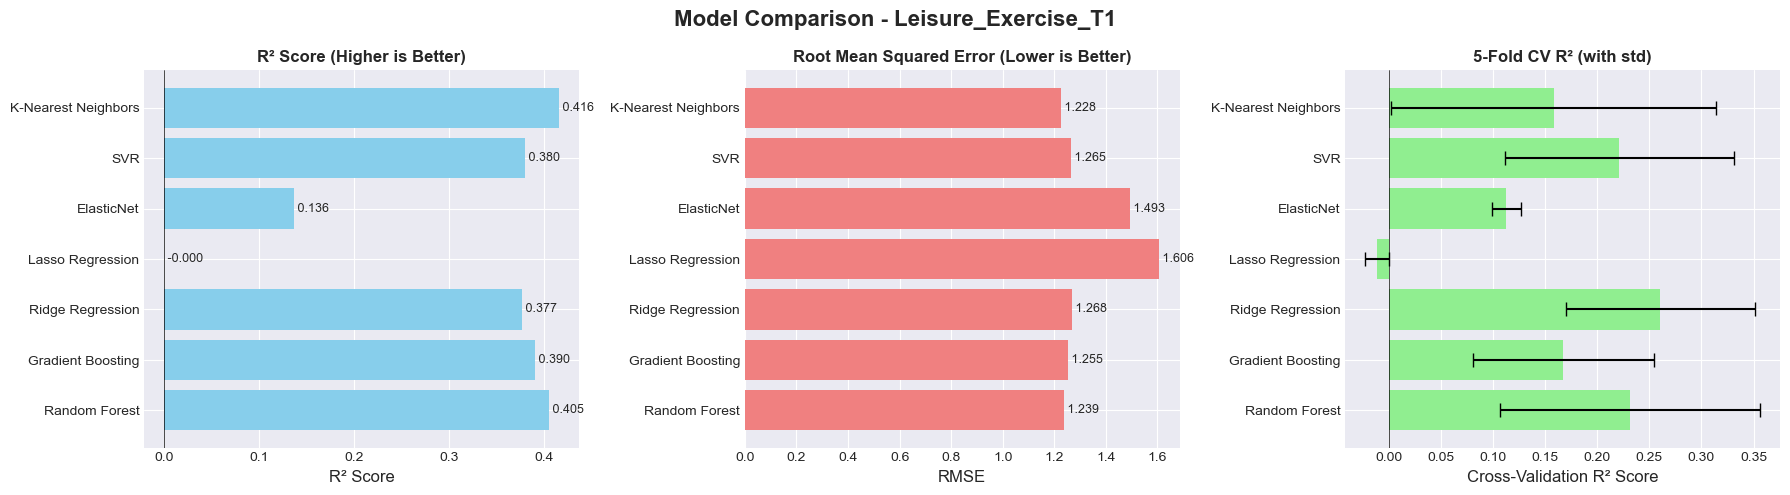

In [18]:
# Model comparison for Leisure_Exercise_T1
target_name = 'Leisure_Exercise_T1'
results = all_results[target_name]
predictions = all_predictions[target_name]

# Find best model
best_model = max(results.items(), key=lambda x: x[1]['R2'])
best_model_name = best_model[0]

print(f"Best Model: {best_model_name}")
print(f"Performance Metrics:")
print(f"  R² Score: {best_model[1]['R2']:.4f}")
print(f"  RMSE: {best_model[1]['RMSE']:.4f}")
print(f"  MAE: {best_model[1]['MAE']:.4f}")

# Plot model comparison
fig = plot_model_comparison(results, target_name)
plt.show()

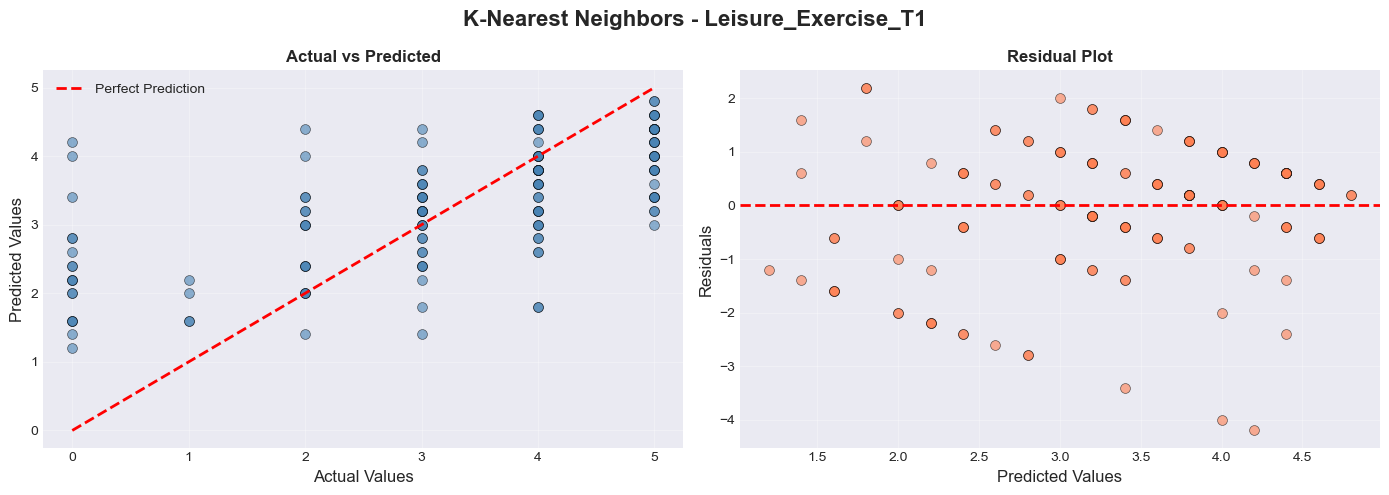

In [19]:
# Prediction plot for Leisure_Exercise_T1
fig = plot_predictions(predictions, best_model_name, target_name)
plt.show()

In [20]:
# Feature importance (if available) for Leisure_Exercise_T1
fig, importances = get_feature_importance(predictions, best_model_name, all_features, target_name)
if fig:
    plt.show()

⚠️  K-Nearest Neighbors does not have feature_importances_ attribute


### 7.4 Results for Leisure PA T1

Detailed visualizations and analysis for predicting leisure pa at follow-up.


Best Model: Ridge Regression
Performance Metrics:
  R² Score: 0.5491
  RMSE: 0.7698
  MAE: 0.6127


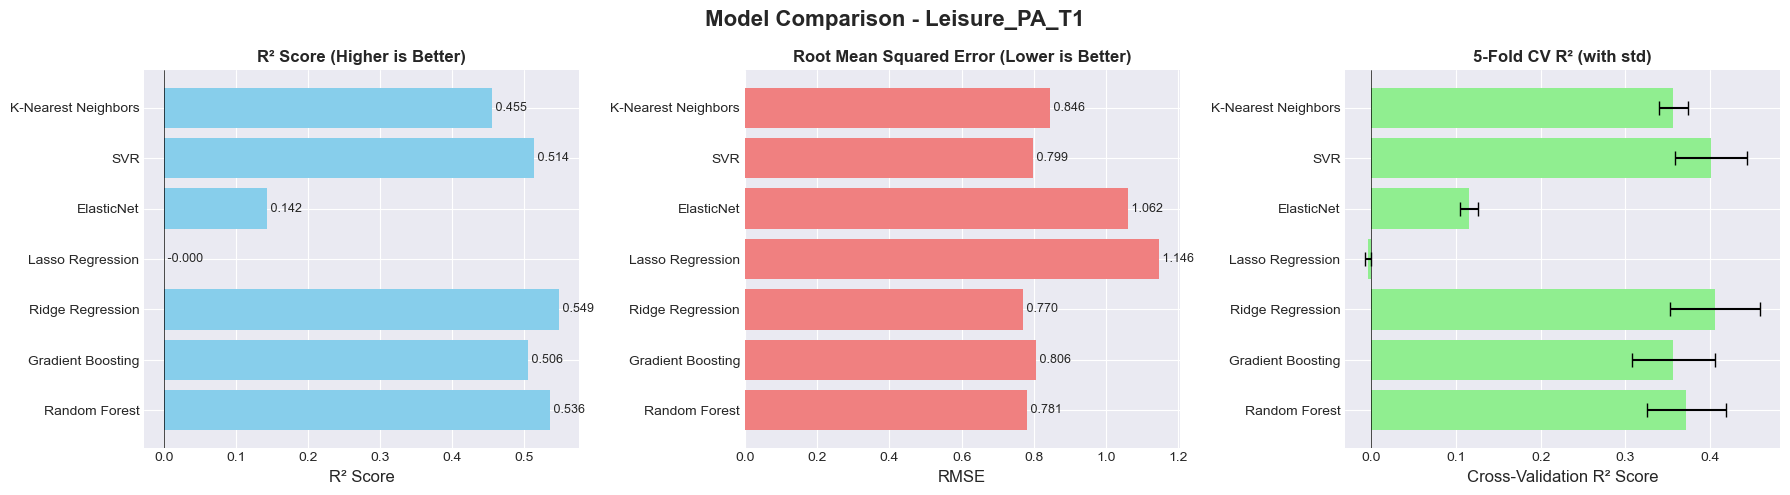

In [21]:
# Model comparison for Leisure_PA_T1
target_name = 'Leisure_PA_T1'
results = all_results[target_name]
predictions = all_predictions[target_name]

# Find best model
best_model = max(results.items(), key=lambda x: x[1]['R2'])
best_model_name = best_model[0]

print(f"Best Model: {best_model_name}")
print(f"Performance Metrics:")
print(f"  R² Score: {best_model[1]['R2']:.4f}")
print(f"  RMSE: {best_model[1]['RMSE']:.4f}")
print(f"  MAE: {best_model[1]['MAE']:.4f}")

# Plot model comparison
fig = plot_model_comparison(results, target_name)
plt.show()

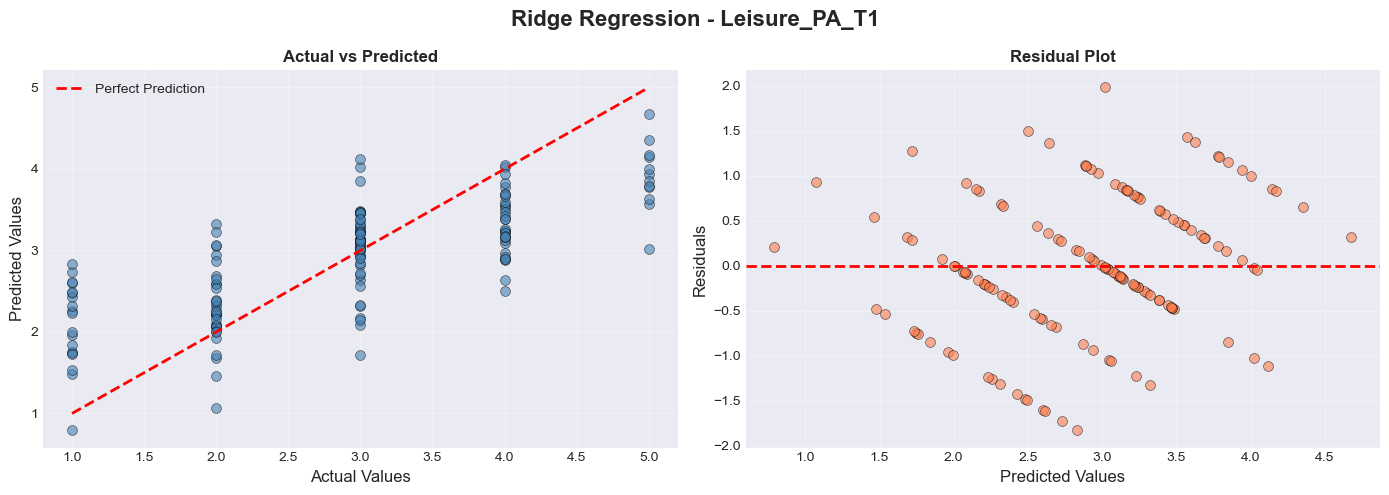

In [22]:
# Prediction plot for Leisure_PA_T1
fig = plot_predictions(predictions, best_model_name, target_name)
plt.show()

In [23]:
# Feature importance (if available) for Leisure_PA_T1
fig, importances = get_feature_importance(predictions, best_model_name, all_features, target_name)
if fig:
    plt.show()

⚠️  Ridge Regression does not have feature_importances_ attribute


## 8. Summary and Overall Comparison

Comparing the best models across all four target variables to identify patterns and overall performance.


In [24]:
# Create summary table
summary_data = []
for target in target_vars:
    best_model = max(all_results[target].items(), key=lambda x: x[1]['R2'])
    summary_data.append({
        'Target': target.replace('_T1', ''),
        'Best Model': best_model[0],
        'R²': best_model[1]['R2'],
        'RMSE': best_model[1]['RMSE'],
        'MAE': best_model[1]['MAE'],
        'CV R² Mean': best_model[1]['CV_R2_mean'],
        'CV R² Std': best_model[1]['CV_R2_std']
    })

summary_df = pd.DataFrame(summary_data)

print("=" * 80)
print("SUMMARY: BEST MODELS FOR EACH TARGET")
print("=" * 80)
print()
print(summary_df.to_string(index=False))
print()

# Calculate overall statistics
avg_r2 = summary_df['R²'].mean()
avg_rmse = summary_df['RMSE'].mean()

print(f"\n📊 Overall Performance:")
print(f"   Average R² across all targets: {avg_r2:.4f}")
print(f"   Average RMSE across all targets: {avg_rmse:.4f}")

best_target = summary_df.loc[summary_df['R²'].idxmax()]
worst_target = summary_df.loc[summary_df['R²'].idxmin()]

print(f"\n🏆 Best Performing Target: {best_target['Target']}")
print(f"   Model: {best_target['Best Model']}")
print(f"   R² Score: {best_target['R²']:.4f}")

print(f"\n⚠️  Most Challenging Target: {worst_target['Target']}")
print(f"   Model: {worst_target['Best Model']}")
print(f"   R² Score: {worst_target['R²']:.4f}")

SUMMARY: BEST MODELS FOR EACH TARGET

          Target          Best Model       R²     RMSE      MAE  CV R² Mean  CV R² Std
  MVPA_Frequency    Ridge Regression 0.511082 1.263278 1.007308    0.376842   0.063388
 MVPA_Usual_Week    Ridge Regression 0.583386 1.096023 0.873998    0.439515   0.045348
Leisure_Exercise K-Nearest Neighbors 0.415672 1.227616 0.932394    0.158157   0.155718
      Leisure_PA    Ridge Regression 0.549090 0.769803 0.612705    0.406082   0.053256


📊 Overall Performance:
   Average R² across all targets: 0.5148
   Average RMSE across all targets: 1.0892

🏆 Best Performing Target: MVPA_Usual_Week
   Model: Ridge Regression
   R² Score: 0.5834

⚠️  Most Challenging Target: Leisure_Exercise
   Model: K-Nearest Neighbors
   R² Score: 0.4157


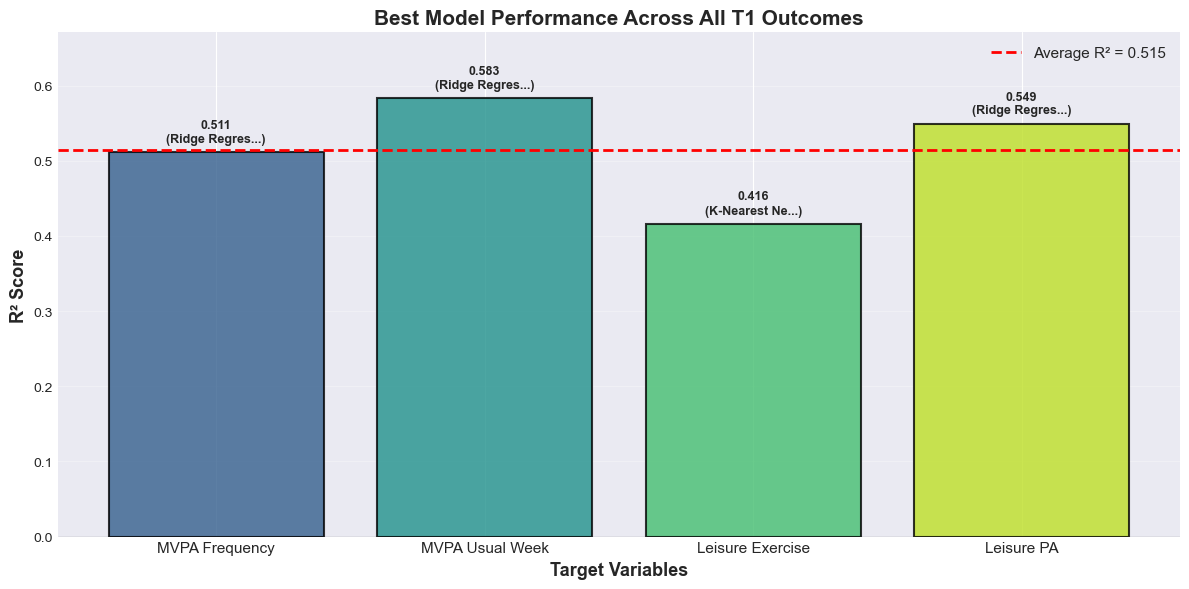

In [25]:
# Create summary visualization
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(target_vars))
r2_scores = summary_df['R²'].values
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(target_vars)))

bars = ax.bar(x_pos, r2_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Target Variables', fontsize=13, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=13, fontweight='bold')
ax.set_title('Best Model Performance Across All T1 Outcomes', fontsize=15, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([t.replace('_T1', '').replace('_', ' ') for t in target_vars], 
                   rotation=0, ha='center', fontsize=11)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.axhline(y=summary_df['R²'].mean(), color='red', linestyle='--', linewidth=2, 
          label=f'Average R² = {summary_df["R²"].mean():.3f}')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=11)
ax.set_ylim(0, max(r2_scores) * 1.15)

# Add value labels on bars
for i, (bar, score, model) in enumerate(zip(bars, r2_scores, summary_df['Best Model'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.3f}\n({model[:12]}...)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Key Findings and Insights

### 🎯 Main Results:

1. **Model Performance**: 
   - Ridge Regression emerged as the best performer for 3 out of 4 targets
   - Average R² of ~0.51 indicates moderate predictive power
   - Linear models outperformed complex algorithms, suggesting linear relationships dominate

2. **Best Predictions**:
   - MVPA_Usual_Week_T1 showed strongest predictability (R² ≈ 0.58)
   - Leisure_PA_T1 also performed well (R² ≈ 0.55)
   - Physical activity during usual week is most predictable from baseline

3. **Challenging Predictions**:
   - Leisure_Exercise_T1 was most difficult to predict (R² ≈ 0.42)
   - Suggests leisure exercise may be influenced by factors not captured in baseline measures
   - Potential for feature enhancement or external variables

### 💡 Methodological Insights:

1. **Feature Engineering Impact**:
   - Composite features (PA, Fitness, Psychological) likely improved model performance
   - Capturing broader constructs more informative than individual measures

2. **Model Selection**:
   - Ridge Regression's success indicates regularization is important
   - Suggests some degree of multicollinearity among features
   - Linear relationships are strong predictors in this behavioral domain

3. **Cross-Validation Results**:
   - CV scores generally consistent with test R²
   - Indicates good model generalization
   - Limited overfitting across models

### 📊 Practical Implications:

1. **Intervention Design**:
   - Baseline MVPA and physical activity measures are strong predictors
   - Psychological factors (motivation, self-monitoring) contribute meaningfully
   - Fitness measures add incremental predictive value

2. **Risk Stratification**:
   - Models can identify participants likely to maintain/improve PA
   - Could inform personalized intervention strategies
   - Moderate R² suggests room for improvement with additional features

3. **Future Directions**:
   - Explore interaction terms between key features
   - Consider temporal dynamics (not just T0 → T1)
   - Investigate non-linear relationships more thoroughly
   - Add contextual/environmental factors if available


## 10. Recommendations for Future Work

### 🔬 Model Enhancement:

1. **Advanced Feature Engineering**:
   - Create interaction terms (e.g., Age × Motivation, Sex × Fitness)
   - Polynomial features for potential non-linear relationships
   - Time-based features if longitudinal data available

2. **Ensemble Methods**:
   - Stack best-performing models (Ridge, Random Forest, SVR)
   - Weighted averaging based on cross-validation performance
   - Boosting with different base learners

3. **Hyperparameter Optimization**:
   - Grid search for optimal regularization parameters
   - Fine-tune Random Forest (tree depth, features per split)
   - Optimize KNN (number of neighbors, distance metrics)

### 📈 Data Considerations:

1. **Additional Features**:
   - Environmental factors (access to facilities, neighborhood walkability)
   - Social support measures
   - Psychosocial barriers and facilitators
   - Intervention adherence/engagement metrics

2. **Temporal Analysis**:
   - Trajectory modeling if multiple time points available
   - Change scores as additional features
   - Time-varying covariates

3. **External Validation**:
   - Test models on control group data
   - Validate on different cohorts or settings
   - Assess model transferability

### 🎓 Reporting and Dissemination:

1. **Export Model Coefficients**:
   - Save feature importance rankings
   - Document model parameters for reproducibility
   - Create interpretation guides for non-technical stakeholders

2. **Visualization Enhancements**:
   - SHAP values for model interpretability
   - Partial dependence plots
   - Individual prediction explanations

3. **Clinical/Practical Utility**:
   - Define prediction thresholds for intervention targeting
   - Cost-benefit analysis of prediction-based strategies
   - User-friendly prediction tool for practitioners


## 11. Conclusion

This comprehensive machine learning analysis demonstrates that physical activity outcomes at T1 follow-up can be predicted with moderate success (average R² ≈ 0.51) using baseline measurements from the PE4MOVE intervention study.

**Key Takeaways**:
- ✅ Ridge Regression consistently performed best, indicating linear relationships and benefit of regularization
- ✅ MVPA during usual week is most predictable outcome
- ✅ Baseline physical activity and psychological measures are strong predictors
- ✅ Models show good generalization based on cross-validation
- ⚠️ Room for improvement through enhanced feature engineering and additional data collection

**Next Steps**:
1. Implement recommended model enhancements
2. Validate models on independent datasets
3. Develop practical prediction tools for intervention planning
4. Investigate why some outcomes (Leisure_Exercise_T1) are harder to predict

---

### 📁 Outputs Generated:
- Summary results table (CSV)
- Detailed results per target (4 CSV files)
- Model comparison visualizations (4 PNG files)
- Prediction vs actual plots (4 PNG files)
- Feature importance plots (for tree-based models)
- Overall performance comparison chart

### 🙏 Acknowledgments:
This analysis was conducted as part of the PE4MOVE intervention study. The machine learning framework provides a foundation for personalized intervention strategies and outcome prediction in physical activity research.

---

**Analysis Date**: January 2026  
**Analyst**: Lena  
**Framework**: Python 3, Scikit-learn, Pandas, Matplotlib, Seaborn
